In [187]:
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import numpy as np
from climpred import HindcastEnsemble
import climpred

In [188]:
def decode_cf(ds, time_var):
    if ds[time_var].attrs['calendar'] == '360':
        ds[time_var].attrs['calendar'] = '360_day'
    ds = xr.decode_cf(ds, decode_times=True)
    return ds

In [189]:
# Nino34 box
minlon=190
maxlon=240
minlat=-5
maxlat=5

# Years
yrmin = '1982-01-01'
yrmax = '2010-12-01'

# Months per year
nmpyr=12

In [190]:
# Get NMME data for NCEP-CFSv2, SST
url = 'http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/NCEP-CFSv2/.HINDCAST/.MONTHLY/.sst/dods'
fullda = decode_cf(xr.open_dataset(url, decode_times=False, chunks={'S': 1, 'L': 12}), 'S')

In [191]:
# Make S (init) Dimension datetime & use first of month for date time step (e.g. Monthly Mean for Jan 1982 is 1982-01-01)
fullda['S']=pd.to_datetime(fullda.S.values.astype(str))
fullda['S']=pd.to_datetime(fullda['S'].dt.strftime('%Y%m01 00:00'))

In [192]:
# Make sure lead is an integer: NMME leads are 0.5, 1.5, 2.5, etc, which correspond to 0, 1, 2, ... months since initialization, I think
fullda['L']=(fullda['L']-0.5).astype('int')

In [193]:
# Rename dimensions for clim pred Hindcast Ensemble object
fcst=fullda.rename({'S': 'init','L': 'lead','M': 'member', 'X': 'lon', 'Y': 'lat'})
fcst['lead'].attrs={'units': 'months'}

In [194]:
# Calculate nino34
fcst=fcst.sel(lat=slice(minlat,maxlat),lon=slice(minlon,maxlon)).mean(['lat','lon'])

In [195]:
# Subset lead, and times
fcst=fcst.sel(init=slice(yrmin,yrmax))

In [196]:
# Make anomalies
fcstclimo = fcst.groupby('init.month').mean('init')
fcstanoms = (fcst.groupby('init.month') - fcstclimo)

In [197]:
# Get verification data
obsurl='http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.OIv2_SST/.sst/dods'
obsda = decode_cf(xr.open_dataset(obsurl, decode_times=False),'T')
obsda['T']=pd.to_datetime(obsda.T.values.astype(str))
obsda['T']=pd.to_datetime(obsda['T'].dt.strftime('%Y%m01 00:00'))

In [198]:
# Rename dimensions for clim pred Hindcast Ensemble object
obs=obsda.rename({'T': 'time','X': 'lon', 'Y': 'lat'})

In [199]:
# Calculate nino34
obs=obs.sel(lat=slice(minlat,maxlat),lon=slice(minlon,maxlon)).mean(['lat','lon'])

In [200]:
# Subset data time
obs=obs.sel(time=slice(yrmin,yrmax))

In [201]:
# Make anomalies
obsclimo = obs.groupby('time.month').mean('time')
obsanoms = obs.groupby('time.month') - obsclimo

In [202]:
# Calculate the skill by month
skill=np.zeros((fcstanoms['lead'].size, nmpyr))
for im in np.arange(0,nmpyr):
    hindcast = HindcastEnsemble(fcstanoms.sel(init=fcstanoms['init.month']==im+1))
    hindcast = hindcast.add_reference(obsanoms, 'observations')
    skillds = hindcast.compute_metric(metric='acc')
    skill[:,im]=skillds['sst'].values

Text(0, 0.5, 'Lead Time (Months)')

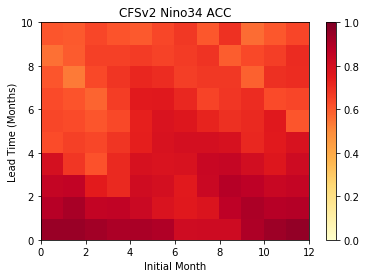

In [203]:
# Plot initial vs. Lead ACC Skill
plt.pcolormesh(skill,cmap=plt.cm.YlOrRd,vmin=0.0,vmax=1.0)
plt.colorbar()
plt.title('CFSv2 Nino34 ACC')
plt.xlabel('Initial Month')
plt.ylabel('Lead Time (Months)')